# Binary Image Classification with a Neural Network

The following project implements a neural network with an arbitrary number of layers and dimensions to solve binary image classification of handwritten digits, for which we must identify which ones are 5 and which ones are not. For context:

- Dataset used: https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset
- Activation function for output layer: sigmoid
- Activation function for hidden layers: ReLU 
- Cost function: calculated using cross-entropy loss

In [1]:
import numpy as np
import copy
import itertools
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import matplotlib.pyplot as plt
import sklearn.metrics

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data preparation

In [191]:
dataset = sklearn.datasets.load_digits()

# Flatten 8x8 features per digit
X = dataset.images.reshape(dataset.images.shape[0],-1)

# Standardize feature values
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Convert target to binary since we are only interested in classifying 5 versus not 5
Y = np.where(dataset.target == 5, 1, 0).reshape((dataset.target.shape[0],1))

# Split data into training and testing
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(X,Y,test_size=0.3,random_state=11)

X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T
Y_test = Y_test.T
print("Shape of X_train:",X_train.shape)
print("Shape of Y_train:",Y_train.shape)
print("Shape of X_test:",X_test.shape)
print("Shape of Y_test:",Y_test.shape)

Shape of X_train: (64, 1257)
Shape of Y_train: (1, 1257)
Shape of X_test: (64, 540)
Shape of Y_test: (1, 540)


## Model Building Blocks

- Initialize parameters
- Propagate forward
- Compute cost
- Propagate backwards
- Update parameters

In [194]:
def initialize_parameters(layer_dimensions:list) -> dict:
    """
    Initializes parameters (weights and biases) for a neural network of given dimensions.

    Arguments:
    ---
    - layer_dimensions: list containing the dimensions of each layer in the network

    Returns:
    ---
    - parameters: dictionary containing parameters "W1", "b1", ..., "WL", "bL":
        - Wl: weight matrix of shape (layer_dims[l], layer_dims[l-1])
        - bl: bias vector of shape (layer_dims[l], 1)
    """

    parameters = {}
    L = len(layer_dimensions)

    for l in range(1, L):
        parameters['W'+str(l)] = np.random.randn(layer_dimensions[l], layer_dimensions[l-1]) * 0.01
        parameters['b'+str(l)] = np.zeros((layer_dimensions[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dimensions[l], layer_dimensions[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dimensions[l], 1))

    return parameters

In [195]:
def sigmoid(Z):
    return  1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def propagate_forward(X:np.ndarray, parameters:dict) -> tuple[np.ndarray,list,list]:
    """
    Propagates calculation forward across hidden layers (ReLU activation) and output layer (sigmoid activation).

    Arguments:
    ---
    - X: data, numpy array of shape (input size, number of examples)
    - parameters: dictionary containing parameters "W1", "b1", ..., "WL", "bL":
        - Wl: weight matrix of shape (layer_dims[l], layer_dims[l-1])
        - bl: bias vector of shape (layer_dims[l], 1)

    Returns:
    ---
    - AL: activation value from the output layer
    - linear_caches: list of linear caches for every layer
    - activation_caches: list of activation caches for every layer
    """

    linear_caches = []
    activation_caches = []
    A = X
    L = len(parameters) // 2

    # Forward propagation for hidden layers (ReLU)
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        Z = np.dot(W,A_prev)+b
        A = relu(Z)
        linear_caches.append((A_prev, W, b))
        activation_caches.append(Z)

    # Forward propagation for output layer (sigmoid)
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    Z = np.dot(W,A)+b
    AL = sigmoid(Z)
    linear_caches.append((A, W, b))
    activation_caches.append(Z)

    return AL, linear_caches, activation_caches

In [196]:
def compute_cost(AL:np.ndarray, Y:np.ndarray) -> float:
    """
    Computes the cross-entropy cost.

    Arguments:
    ---
    - AL: probability vector corresponding to label predictions, shape (1, number of examples)
    - Y: true "label" vector (containing 0 if digit is not five, 1 if digit is five), shape (1, number of examples)

    Returns:
    ---
    - cost: cross-entropy cost    
    """    
    m = Y.shape[1]

    cost = -np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))/m

    # Ensure cost is the dimension we expect (e.g., turns [[17]] into 17)
    cost = np.squeeze(cost)

    return cost

In [197]:
def sigmoid_backward(dA, Z):    
    s = sigmoid(Z)
    dZ = dA * s * (1 - s)
    return dZ

def relu_backward(dA, Z):
    # Copy dA
    dZ = np.array(dA, copy=True)
    # When z <= 0, set dz to 0 as well
    dZ[Z <= 0] = 0
    return dZ


def propagate_backwards(AL, Y, linear_caches:list, activation_caches:list) -> dict:
    """
    Propagates the calculation backwards across output layer (sigmoid activation) and hidden layers (ReLU activation).

    Arguments:
    ---
    - AL: probability vector corresponding to your label predictions, shape (1, number of examples)
    - Y: true "label" vector (containing 0 if digit is not five, 1 if digit is five), shape (1, number of examples)
    - linear_caches: list of linear caches for every layer
    - activation_caches: list of activation caches for every layer

    Returns:
    ---
    - gradients: dictionary containing gradients with respect to different parameters
    """

    gradients = {}
    L = len(linear_caches)
    m = AL.shape[1]

    # Reshape Y to have the same shape as AL
    Y = Y.reshape(AL.shape)

    # Initialize the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Backward propagation for output layer (sigmoid)
    Z = activation_caches[L-1]
    dZ = sigmoid_backward(dAL, Z)
    A_prev, W, b = linear_caches[L-1]
    dW_temp = np.dot(dZ,A_prev.T)/m
    db_temp = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev_temp = np.dot(W.T,dZ)
    gradients["dA" + str(L-1)] = dA_prev_temp
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp

    # Backward propagation for hidden layers (ReLU)
    for l in reversed(range(L-1)):
        Z = activation_caches[l]
        dZ = relu_backward(dA_prev_temp, Z)
        A_prev, W, b = linear_caches[l]
        dW_temp = np.dot(dZ,A_prev.T)/m
        db_temp = np.sum(dZ,axis=1,keepdims=True)/m
        dA_prev_temp = np.dot(W.T,dZ)
        gradients["dA" + str(l)] = dA_prev_temp
        gradients["dW" + str(l+1)] = dW_temp
        gradients["db" + str(l+1)] = db_temp

    return gradients

In [198]:
def update_parameters(parameters:dict, gradients:dict, learning_rate:float) -> dict:
    """
    Updates parameters using the gradient descent.

    Arguments:
    ---
    - parameters: dictionary containing parameters
    - gradients: dictionary containing gradients
    - learning_rate: float representing the learning rate

    Returns:
    ---
    - parameters: dictionary containing updated_parameters
        - parameters["W" + str(l)] = ... 
        - parameters["b" + str(l)] = ...
    """

    parameters = copy.deepcopy(parameters)
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*gradients["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*gradients["db" + str(l+1)]

    return parameters

## Model

In [199]:
def fit(X:np.ndarray, Y:np.ndarray, layer_dimensions:list, learning_rate:float=0.0075, num_iterations:int=3000) -> tuple[dict,list]:
    
    np.random.seed(42)
    costs = []

    # Parameters initialization
    parameters = initialize_parameters(layer_dimensions)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        AL, linear_caches, activation_caches = propagate_forward(X, parameters)

        # Compute cost
        cost = compute_cost(AL, Y)
        costs.append(cost)

        # Backward propagation
        gradients = propagate_backwards(AL, Y, linear_caches, activation_caches)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

    return parameters, costs

In [205]:
def predict(X:np.ndarray, Y:np.ndarray, parameters:dict) -> np.ndarray:
    Y_predicted, _, _ = propagate_forward(X, parameters)
    Y_predicted = (Y_predicted>0.5).astype(int)
    print(f"Accuracy: {100 - np.mean(np.abs(Y_predicted - Y)) * 100} %")
    return Y_predicted

## Results

### Train Accuracy

In [206]:
params, cost = fit(X_train,Y_train,layer_dimensions=[64,12,1])
Y_predicted_train = predict(X_train,Y_train,params)

Accuracy: 98.56801909307876 %


### Test Accuracy and Confusion Matrix

In [208]:
Y_predicted_test = predict(X_test,Y_test,params)

Accuracy: 99.62962962962963 %


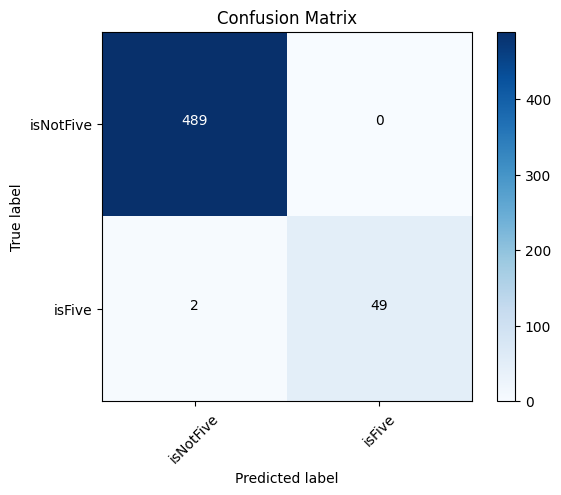

In [213]:
# Compute confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(Y_test.flatten(), Y_predicted_test.flatten())

# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()

labels = ['isNotFive','isFive']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, confusion_matrix[i, j], horizontalalignment="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black")